## 005 : Research Model with Data Augmentation

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../../')
# keras expects data to be encoded in a particular way, to_categorical does this encoding for us (one-hot encoding)
from keras.utils.np_utils import to_categorical
import libs.importing as importing
import pandas as pd
import os
import libs.render as render
import libs.cnn_models as cnn_models
import libs.analysis as analysis
import libs.normalization as normalization
from importlib import reload
import libs.data_prep as data_prep
import numpy as np
from keras.models import load_model

from pylab import rcParams
rcParams['figure.figsize'] = (10,8)

In [3]:
# LOAD PATCH DATA REFERENCES

# directory setup
data_source = '../315f7638'
train_dir = os.path.join(data_source, 'train')
test_dir = os.path.join(data_source, 'test')
val_dir = os.path.join(data_source, 'val')

# get references to the data we want
train_patches_df = pd.read_csv(os.path.join(train_dir, 'patches_cleaned_shuffled.csv'))
train_data_reader = importing.PatchDataReader(os.path.join(train_dir, 'patches'), train_patches_df)

test_patches_df = pd.read_csv(os.path.join(test_dir, 'patches_cleaned_shuffled.csv'))
test_data_reader = importing.PatchDataReader(os.path.join(test_dir, 'patches'), test_patches_df)

val_patches_df = pd.read_csv(os.path.join(val_dir, 'patches_cleaned_shuffled.csv'))
val_data_reader = importing.PatchDataReader(os.path.join(val_dir, 'patches'), val_patches_df)

In [4]:
## READ PATCH DATA

# load train, test, and validation data
x_train, y_train = train_data_reader.read_data()
x_test, y_test = test_data_reader.read_data()
x_val, y_val = val_data_reader.read_data()

# LOG RESULTS
## Visualize the patches
data_prep.log_patch_data_reader(train_dir, train_data_reader)
data_prep.log_patch_data_reader(test_dir, test_data_reader)
data_prep.log_patch_data_reader(val_dir, val_data_reader)

In [5]:
## CONVERT CLASSES TO KERAS FORMAT
# keras expects classes to be number from 0-N, we are using 1-N numbering so we need to convert.
# then we also have to change the classes to one-hot encoding

y_train_oh = to_categorical(y_train - 1)
y_test_oh  = to_categorical(y_test - 1)
y_val_oh   = to_categorical(y_val - 1)

In [6]:
# NORMALIZATION

m, std = normalization.dataset_mean_and_std(x_train)

x_train = (x_train - m) / std
x_test  = (x_test - m) / std
x_val   = (x_val - m) / std

In [8]:
## MODEL : load from file, show summary, and compile
reload(cnn_models)
import keras

model = cnn_models.model_from_previous_research_2class()
display(model.summary())

# parameters:
learning_rate = 1e-4

adam_opt = keras.optimizers.Adam(lr=learning_rate)



model.compile(optimizer = adam_opt, loss = "binary_crossentropy", metrics=["accuracy"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 192)       196800    
_________________________________________________________________
activation_2 (Activation)    (None, 15, 15, 192)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 192)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         442624    
__________

None

In [9]:
data_prep.check_for_nans(x_train)
data_prep.check_for_nans(x_test)
data_prep.check_for_nans(x_val)

print(y_train[:100], y_test[:100], y_val[:100])

[2 2 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 1 2 1] [1 1 2 2 1 2 2 2 2 1 1 1 1 1 1 2 2 1 2 1 1 2 1 2 2 2 2 1 1 1 1 2 1 2 1 2 1
 1 1 1 1 1 2 1 1 1 1 2 2 2 2 2 1 2 1 1 1 2 2 1 1 2 2 2 1 2 2 1 1 1 2 1 1 2
 1 1 1 1 2 1 1 2 1 1 1 2 2 1 1 1 1 2 2 1 2 2 1 1 2 1] [2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 1 2 1 2 2 1 2 2 1 2 2 2 2 2 1
 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2
 1 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 1 2]


In [10]:
epochs = 12
batch_size = 32

history = model.fit(x_train,y_train_oh, batch_size=batch_size,
                              epochs = epochs,
                              validation_data = (x_test,y_test_oh), shuffle=True,
                              verbose = 1, callbacks=[cnn_models.annealer(1)])



Train on 3093 samples, validate on 256 samples
Epoch 1/12
3093/3093 [==============================] - 13s 4ms/step - loss: 0.3690 - acc: 0.8655 - val_loss: 0.7303 - val_acc: 0.5391
Epoch 2/12
3093/3093 [==============================] - 9s 3ms/step - loss: 0.3078 - acc: 0.8725 - val_loss: 0.8779 - val_acc: 0.4766
Epoch 3/12
3093/3093 [==============================] - 9s 3ms/step - loss: 0.2946 - acc: 0.8788 - val_loss: 1.3624 - val_acc: 0.6055
Epoch 4/12
3093/3093 [==============================] - 9s 3ms/step - loss: 0.2553 - acc: 0.8820 - val_loss: 1.0564 - val_acc: 0.5469
Epoch 5/12
3093/3093 [==============================] - 9s 3ms/step - loss: 0.2208 - acc: 0.8988 - val_loss: 1.4109 - val_acc: 0.5078

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 6/12
3093/3093 [==============================] - 9s 3ms/step - loss: 0.1779 - acc: 0.9211 - val_loss: 2.7166 - val_acc: 0.4844

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.4999999

In [11]:
model.save('model_002_r2.h5')

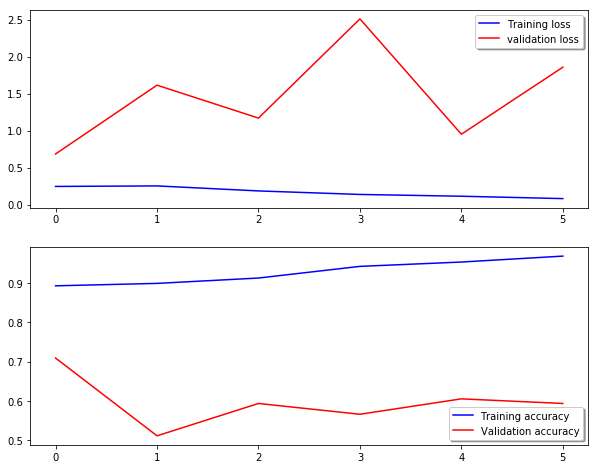

Precision (specificity): 76.714%
Recall (sensitivity): 77.544%
Accuracy: 85.714%
F1: 77.115%


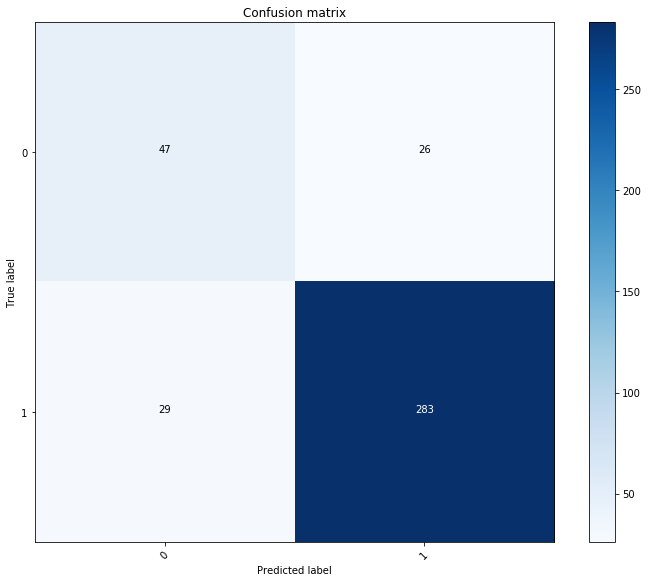

In [17]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [18]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

hgv-8528141b [0.782969   0.21699634] 0
hgv-2cdb69f6 [0.0616425  0.93782234] 0
odi-0294ae4c [0.00281886 0.9971127 ] 1
mdi-f3f9ede5 [1.5339392e-05 9.9998474e-01] 1
hgv-99fc12a1 [0.37262884 0.6276702 ] 0
hgv-6d2317b0 [0.2724788 0.7280048] 1


In [7]:
## FIXES :::

model = load_model('model_002_r2.h5')
#model.summary()

Precision (specificity): 73.828%
Recall (sensitivity): 74.324%
Accuracy: 83.896%
F1: 74.070%


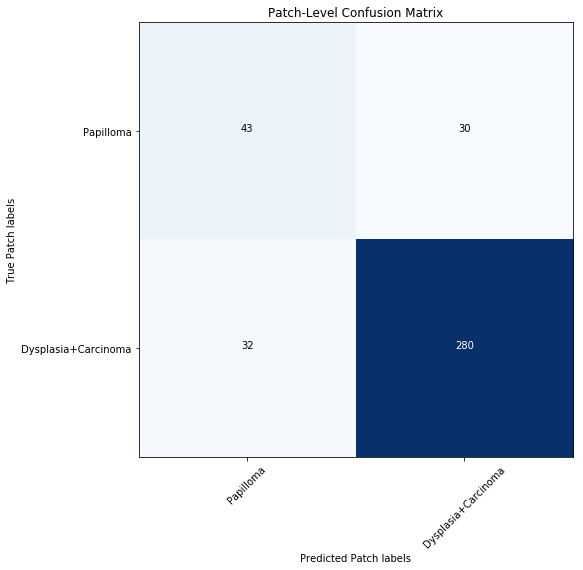

In [16]:
reload(analysis)
reload(render)
from pylab import rcParams
rcParams['figure.figsize'] = (8, 8) # constant figure size

## PATCH LEVEL STATISTICS

# predictions
y_pred_oh = model.predict(x_val)
cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix_fix(cm, num_classes=2,
                                 labels=['Papilloma', 'Dysplasia+Carcinoma'], stat_type='patch', save='exp3_patch_level_cm')

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [8]:
## ROI Level Statistics
reload(analysis)
reload(render)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))

preds, truths = analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))
#print(preds, truths)
cm = analysis.roi_cm(truths, preds)
cm_norm = analysis.normalize_roi_cm(cm)
print(cm)

analysis.roi_stats_2class(cm_norm)

hgv-8528141b [0.6992242  0.30129722] 0
hgv-2cdb69f6 [0.07200842 0.9278318 ] 0
odi-0294ae4c [6.632832e-04 9.993333e-01] 1
mdi-f3f9ede5 [7.982084e-06 9.999919e-01] 1
hgv-99fc12a1 [0.30495667 0.69509435] 0
hgv-6d2317b0 [0.2533551 0.7466219] 1
[[1.0761893  1.9242234 ]
 [0.25402635 2.7459471 ]]
Precision (specificity): 58.797%
Recall (sensitivity): 91.533%
Accuracy: 63.698%


In [ ]:
# cleanup
import keras.backend as K
K.clear_session()

In [9]:
## Now Let's do a run with data augmentation
reload(cnn_models)
from keras.preprocessing.image import ImageDataGenerator

epochs2 = 6
batch_size2 = 64

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=45,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                     # Randomly zoom image 
        width_shift_range=0.15,               # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,              # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=False)                  # randomly flip images


datagen.fit(x_train)


history = model.fit_generator(datagen.flow(x_train,y_train_oh, batch_size=batch_size2),
                              epochs = epochs2, validation_data = (x_test,y_test_oh),
                              workers = 4,
                              verbose = 1, steps_per_epoch = x_train.shape[0] # batch_size
                              , callbacks=[cnn_models.annealer()])

Epoch 1/6
3789/3789 [==============================] - 425s 112ms/step - loss: 0.2545 - acc: 0.9141 - val_loss: 0.5536 - val_acc: 0.8306
Epoch 2/6
3789/3789 [==============================] - 422s 111ms/step - loss: 0.2061 - acc: 0.9266 - val_loss: 0.2544 - val_acc: 0.9118
Epoch 3/6
3789/3789 [==============================] - 422s 111ms/step - loss: 0.1813 - acc: 0.9356 - val_loss: 0.2343 - val_acc: 0.8994
Epoch 4/6
3789/3789 [==============================] - 423s 112ms/step - loss: 0.1551 - acc: 0.9432 - val_loss: 0.1594 - val_acc: 0.9380
Epoch 5/6
3789/3789 [==============================] - 422s 111ms/step - loss: 0.1393 - acc: 0.9494 - val_loss: 0.0843 - val_acc: 0.9711
Epoch 6/6
3789/3789 [==============================] - 421s 111ms/step - loss: 0.1246 - acc: 0.9541 - val_loss: 0.3433 - val_acc: 0.9174


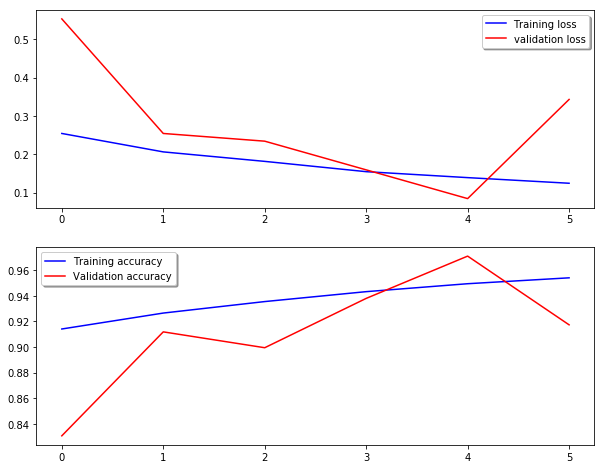

Precision (specificity): 91.541%
Recall (sensitivity): 88.206%
Accuracy: 89.568%
F1: 89.041%


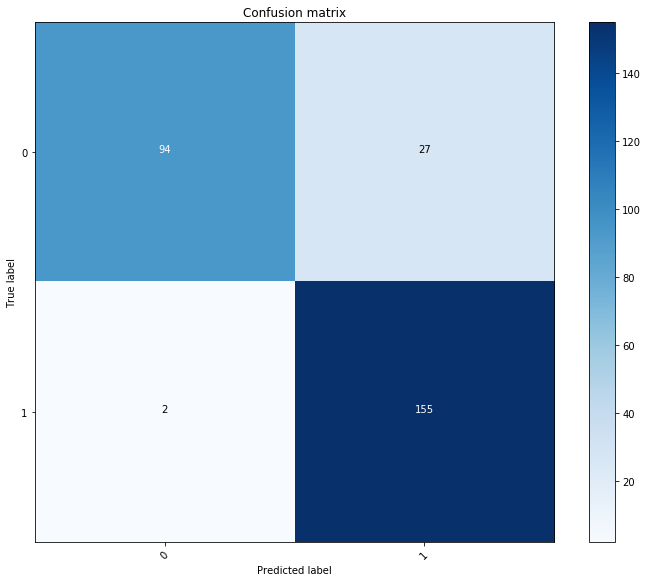

In [10]:
render.plot_training_and_validation_curves(history)
y_pred_oh = model.predict(x_val)

cm = render.setup_confusion_matrix(y_pred_oh, x_val, y_val_oh)

render.plot_confusion_matrix(cm, num_classes=2)

scores = analysis.get_scores_oh(y_val_oh, y_pred_oh)
analysis.print_scores(scores)

In [11]:
## CONTOUR LEVEL ANALYSIS
reload(analysis)

analysis.plot_contour_predictions(val_data_reader, model, val_dir, norm_data=(m, std))
analysis.contour_statistics(val_data_reader, model, val_dir, norm_data=(m, std))

odi-b43ee406 [5.201510e-04 9.995467e-01] 0
hgv-453fea32 [0.7201388 0.2811789] 0
mdi-461bdebc [0.8900543  0.11170609] 0
mdi-9ce9698b [0.02331662 0.97656125] 1
mdi-f5cb6906 [0.02536538 0.9749691 ] 1
mdi-945f5ac6 [0.01265694 0.9874715 ] 1


In [11]:
model.save('model_005_research_model_no_dropout.h5')